In [1]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import math
import seaborn as sns
#install pip install squarify in anconda prompt before importing
import squarify

In [2]:
# Read dataset
online = pd.read_csv("C:/Users/DIVYA/Downloads/online_retail_data.csv")
online.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_price,gender,Age
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085,United Kingdom,83.4,male,22
1,1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085,United Kingdom,81.0,male,22
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085,United Kingdom,81.0,male,22
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085,United Kingdom,100.8,male,22
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085,United Kingdom,30.0,male,22


In [3]:
online.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
#online.head()

In [5]:
# Convert InvoiceDate from object to datetime format
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [6]:
print('{:,} rows; {:,} columns'
      .format(online.shape[0], online.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(online[online["Customer ID"].isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(online['InvoiceDate'].min(),
                                    online['InvoiceDate'].max()))

824,364 rows; 11 columns
0 transactions don't have a customer id
Transactions timeframe from 2009-12-01 07:45:00 to 2011-12-09 12:50:00


In [7]:
# --Group data by customerID--
# Create TotalSum column for online dataset
online['Total_price'] = online['Quantity'] * online['Price']

In [8]:
# Create snapshot date
snapshot_date = online['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [9]:
# Grouping by CustomerID
data_process = online.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Invoice': 'count',
        'Total_price': 'sum'})

In [10]:
# Rename the columns 
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'Total_price': 'MonetaryValue'}, inplace=True)

In [11]:
# Print top 5 rows and shape of dataframe
print(data_process.head())
print('{:,} rows; {:,} columns'
      .format(data_process.shape[0], data_process.shape[1]))

             Recency  Frequency  MonetaryValue
Customer ID                                   
12346            326         48      155177.60
12347              2        253        5633.32
12348             75         51        2019.40
12349             19        180        4452.84
12350            310         17         334.40
5,942 rows; 3 columns


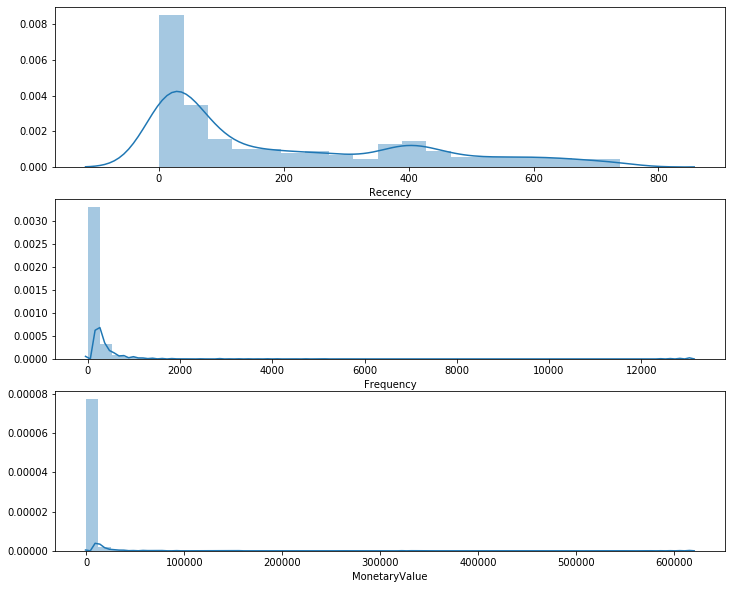

In [12]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

In [13]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(1,5); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)

In [14]:
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
Customer ID,,,,,
12346,326,48,155177.60,3,2
12347,2,253,5633.32,1,4
12348,75,51,2019.40,2,2
12349,19,180,4452.84,1,4
12350,310,17,334.40,3,1


In [15]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [16]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
Customer ID,,,,,,,
12346,326,48,155177.60,3,2,4,324
12347,2,253,5633.32,1,4,4,144
12348,75,51,2019.40,2,2,3,223
12349,19,180,4452.84,1,4,4,144
12350,310,17,334.40,3,1,1,311


In [17]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

60


In [18]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

Customer ID
12346    9.0
12347    9.0
12348    7.0
12349    9.0
12350    5.0
Name: RFM_Score, dtype: float64


In [19]:
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
Customer ID,,,,,,,,,
12346,326,48,155177.60,3,2,4,324,9.0,Can't Loose Them
12347,2,253,5633.32,1,4,4,144,9.0,Can't Loose Them
12348,75,51,2019.40,2,2,3,223,7.0,Loyal
12349,19,180,4452.84,1,4,4,144,9.0,Can't Loose Them
12350,310,17,334.40,3,1,1,311,5.0,Promising


In [20]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't Loose Them     150.7     317.7        7490.9  2029
Champions            214.6      90.1        1714.6   973
Loyal                229.3      51.8         923.7   998
Needs Attention       42.5      14.2         251.4   224
Potential            343.8      23.3         716.4  1088
Promising            143.2      20.0         361.2   541
Require Activation    14.1      10.4         204.1    89


findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.


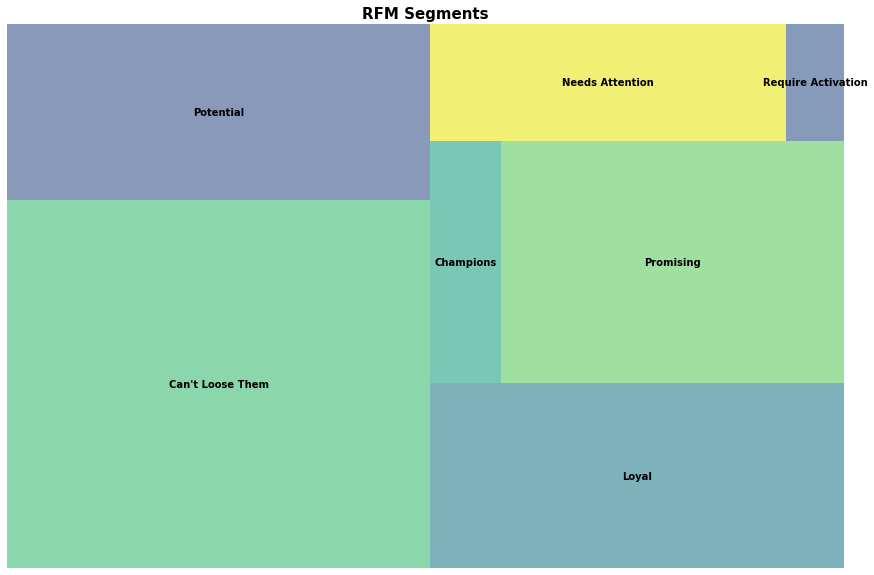

In [21]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 10)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Potential',
                     'Loyal',
                     'Champions',
                     'Promising', 
                     'Needs Attention', 
                     'Require Activation'], text_kwargs={'fontsize':10,'fontname':"Times New Roman Bold",
                                                                         'weight':'bold'},alpha=.6 )
plt.title("RFM Segments",fontsize=15,fontweight="bold")
plt.axis('off')
plt.show()